# Churn analysis for E-Commerce

The purpose of this analysis is creating a model that preditcs churn on customers from an E-Commerce store.

In [1]:
# Importing all packages needed
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Sets theme for the charts displayed
sns.set_theme(context='notebook',style="whitegrid",palette='Set2')

In [ ]:
# Initializes the connection with the API from Kaggle
kaggle_token = {"username":"","key":""}

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [ ]:
churn_datasets = pd.DataFrame(api.datasets_list(search='Ecommerce Customer Churn Analysis and Prediction')).head()

In [ ]:
ref = churn_datasets.loc[0,'ref']
!kaggle datasets download -d {ref}

In [ ]:
#The documents from the Zip File are extracted
zf = ZipFile('ecommerce-customer-churn-analysis-and-prediction.zip')
zf.extractall()
zf.close()

In [37]:
#Both sheets of the file are read
churn_dict = pd.read_excel('E Commerce Dataset.xlsx',sheet_name='Data Dict',header=1)
churn_dict.drop(['Unnamed: 0','Data'],axis=1,inplace=True)

churn_df = pd.read_excel('E Commerce Dataset.xlsx',sheet_name='E Comm')

In [38]:
for row in range(len(churn_dict)):
    print(churn_dict.loc[row,'Variable'],': ', churn_dict.loc[row,'Discerption']) 

CustomerID :  Unique customer ID
Churn :  Churn Flag
Tenure :  Tenure of customer in organization
PreferredLoginDevice :  Preferred login device of customer
CityTier :  City tier
WarehouseToHome :  Distance in between warehouse to home of customer
PreferredPaymentMode :  Preferred payment method of customer
Gender :  Gender of customer
HourSpendOnApp :  Number of hours spend on mobile application or website
NumberOfDeviceRegistered :  Total number of deceives is registered on particular customer
PreferedOrderCat :  Preferred order category of customer in last month
SatisfactionScore :  Satisfactory score of customer on service
MaritalStatus :  Marital status of customer
NumberOfAddress :  Total number of added added on particular customer
Complain :  Any complaint has been raised in last month
OrderAmountHikeFromlastYear :  Percentage increases in order from last year
CouponUsed :  Total number of coupon has been used in last month
OrderCount :  Total number of orders has been places i

In [39]:
# Preview of the dataset
churn_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [40]:
# Analyzing null values
print(churn_df.shape)
print(churn_df.isnull().sum() / len(churn_df.CustomerID))

(5630, 20)
CustomerID                     0.000000
Churn                          0.000000
Tenure                         0.046892
PreferredLoginDevice           0.000000
CityTier                       0.000000
WarehouseToHome                0.044583
PreferredPaymentMode           0.000000
Gender                         0.000000
HourSpendOnApp                 0.045293
NumberOfDeviceRegistered       0.000000
PreferedOrderCat               0.000000
SatisfactionScore              0.000000
MaritalStatus                  0.000000
NumberOfAddress                0.000000
Complain                       0.000000
OrderAmountHikeFromlastYear    0.047069
CouponUsed                     0.045471
OrderCount                     0.045826
DaySinceLastOrder              0.054529
CashbackAmount                 0.000000
dtype: float64


Missing values are not representative portions of the total data, therefore, we can keep all columns and impute those missing values.

## Exploratory analysis

An exploratory analysis will be performed to understand better the customers we have.

In [41]:
churn_df['CustomerID'] = churn_df['CustomerID'].astype(str)

In [42]:
churn_df.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,5630,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,52490,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,NaN,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,NaN,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,NaN,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,NaN,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,NaN,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500


#### Defining churn
As we have a "DaySinceLastOrder" and a "Churn" feature, it is important to define churn in a way that is not related to the days when the customer has not had a purchase on the ecommerce platform. Example: If we define a churned customer as a customer that hasn't bought for more than 30 days, then when someone is categorized as churned and the last purchase was 15 days ago, we will have discrepancies.
Therefore, we will define a churned customer as someone who deleted the account of the ecommerce.

In [47]:
# Verifying that there are no customers with less than 1 year of tenure and null value for Order Amount Hike from last year
churn_df[(churn_df['OrderAmountHikeFromlastYear'].isnull() ) & (churn_df['Tenure']<1)]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


In [50]:
# Imputing missing values
# All of the features are continous, therefore, we can impute the median for all of the missing values

missing_cols = ['Tenure','WarehouseToHome','HourSpendOnApp','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']
medians = churn_df[missing_cols].median()

In [51]:
for col in missing_cols:
    churn_df[col] = np.where(churn_df[col].isnull(), churn_df[col].median(), churn_df[col])

In [52]:
# Only for better visualization
churn_df['churn_flag'] = np.where(churn_df['Churn']==1,'Yes','No')
churn_df['complain_flag'] = np.where(churn_df['Complain']==1, 'Yes','No')

In [53]:
churn_percent = churn_df.groupby('churn_flag',as_index=False)['CustomerID'].count().sort_values('CustomerID')
churn_percent['percent'] = 100*churn_percent['CustomerID'] / sum(churn_percent['CustomerID'])

gender_percent = churn_df.groupby(['Gender'],as_index=False)['CustomerID'].count().sort_values('CustomerID')
gender_percent['percent'] = 100*gender_percent['CustomerID'] / sum(gender_percent['CustomerID'])

marital_percent = churn_df.groupby('MaritalStatus',as_index=False)['CustomerID'].count().sort_values('CustomerID')
marital_percent['percent'] = 100*marital_percent['CustomerID'] / sum(marital_percent['CustomerID'])

device_percent = churn_df.groupby('PreferredLoginDevice',as_index=False)['CustomerID'].count().sort_values('CustomerID')
device_percent['percent'] = 100*device_percent['CustomerID'] / sum(device_percent['CustomerID'])

paymentmode_percent = churn_df.groupby('PreferredPaymentMode',as_index=False)['CustomerID'].count().sort_values('CustomerID')
paymentmode_percent['percent'] = 100 * paymentmode_percent['CustomerID'] / sum(paymentmode_percent['CustomerID'])

prefcategories_percent = churn_df.groupby('PreferedOrderCat',as_index=False)['CustomerID'].count().sort_values('CustomerID')
prefcategories_percent['percent'] = 100 * prefcategories_percent['CustomerID'] / sum(prefcategories_percent['CustomerID'])


In [54]:
gender_mar = churn_df.groupby(['Gender','MaritalStatus'],as_index=False)['CustomerID'].count().merge(gender_percent[['Gender','CustomerID']], on='Gender')
gender_mar['percent'] = 100 * gender_mar['CustomerID_x'] / gender_mar['CustomerID_y']

city_complain = churn_df.groupby(['CityTier','complain_flag'],as_index=False)['CustomerID'].count().merge(churn_df.groupby('CityTier',as_index=False)['CustomerID'].count(),on='CityTier')
city_complain['percent'] = city_complain['CustomerID_x']*100 / city_complain['CustomerID_y']

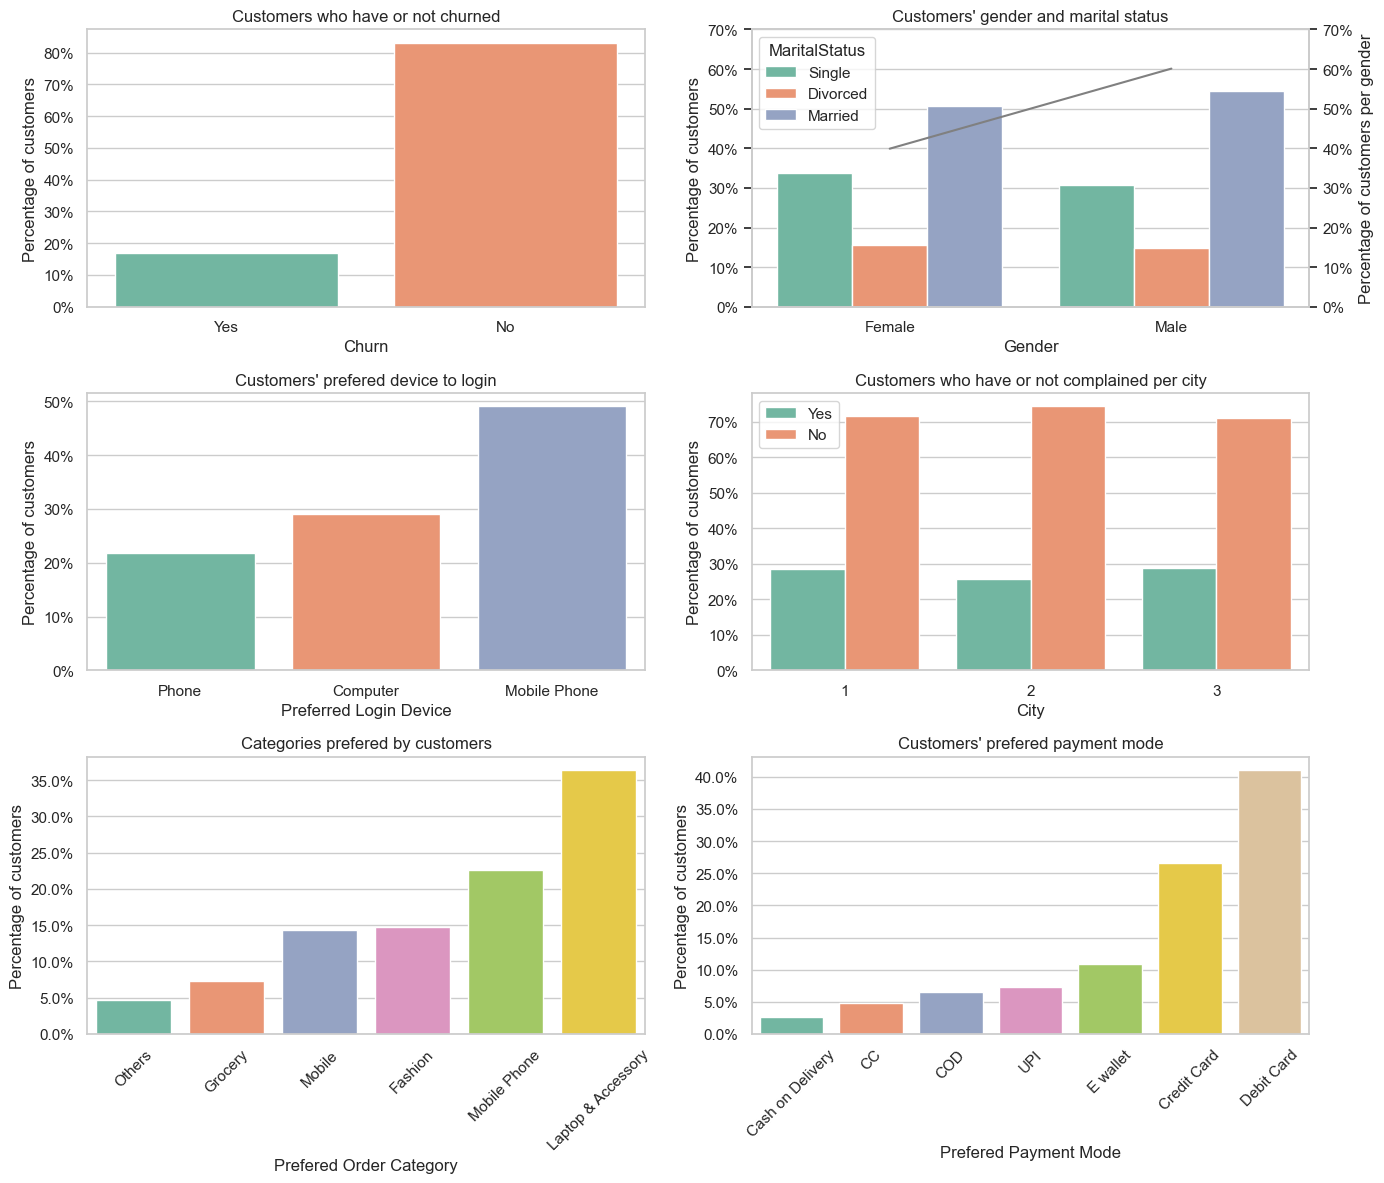

In [31]:
fig, axes = plt.subplots(3,2, figsize=(14,12))
plt.rcParams["figure.autolayout"] = True

sns.barplot(data=churn_percent,x='churn_flag',y='percent',ax=axes[0,0])
axes[0,0].set_xlabel('Churn')
axes[0,0].set_title("Customers who have or not churned")

ax_01 = sns.barplot(data=gender_mar,x='Gender',y='percent',hue='MaritalStatus',ax=axes[0,1],hue_order=['Single','Divorced','Married'])
ax_01.set_yticks(np.arange(0,80,10))
ax_01.set_ylim(0,70)
ax_01twin = ax_01.twinx()
ax_01twin.set_ylim(0,70)
sns.lineplot(data=gender_percent, y='percent',x='Gender',ax=ax_01twin,color='grey')
ax_01twin.grid(False)
ax_01twin.set_ylabel('Percentage of customers per gender')
ax_01twin.set_yticks(np.arange(0,80,10))
ax_01twin.yaxis.set_major_formatter(mtick.PercentFormatter())
axes[0,1].set_title("Customers' gender and marital status")

sns.barplot(data=device_percent, x='PreferredLoginDevice',y='percent',ax=axes[1,0])
axes[1,0].set_xlabel('Preferred Login Device')
axes[1,0].set_title("Customers' prefered device to login")

sns.barplot(data=prefcategories_percent, x='PreferedOrderCat',y='percent',ax=axes[2,0])
axes[2,0].set_xticklabels(prefcategories_percent['PreferedOrderCat'], rotation=45)
axes[2,0].set_xlabel('Prefered Order Category')
axes[2,0].set_title("Categories prefered by customers")

sns.barplot(data=city_complain, x='CityTier',y='percent',hue='complain_flag', ax=axes[1,1],hue_order=['Yes','No'])
axes[1,1].legend(loc='upper left')
axes[1,1].set_xlabel('City')
axes[1,1].set_title("Customers who have or not complained per city")

sns.barplot(data=paymentmode_percent,x='PreferredPaymentMode',y='percent',ax=axes[2,1])
axes[2,1].set_xticklabels(paymentmode_percent['PreferredPaymentMode'], rotation=45)
axes[2,1].set_xlabel('Prefered Payment Mode')
axes[2,1].set_title("Customers' prefered payment mode")

for i in range(3):
    for j in range(2):
        axes[i,j].yaxis.set_major_formatter(mtick.PercentFormatter())
        axes[i,j].set_ylabel('Percentage of customers')


# plt.suptitle('Categorical features analysis',fontsize=16)
plt.show()

According to the charts above:
* 83% of customers haven't churned, which is a good sign.
* The company has mostly male customers, and for both genders, around 50% of customers are married.
* The prefered device in which customers login are mobile phones by almost 50%.
* Only around 30% of customers have complained. Customers from city number 2 have complain the less.
* Electronic devices such as mobile phones, laptops and accesories are the most prefered categories for customers.
* 65% percent of customers prefer to pay with credit or debit card.

In [55]:
# We only make these groups because they dont have too many values, so its easier to see
satisfaction_score_percent = churn_df.groupby("SatisfactionScore",as_index=False)['CustomerID'].count()
satisfaction_score_percent['percent'] = 100 * satisfaction_score_percent['CustomerID'] / sum(satisfaction_score_percent['CustomerID'])

hours_spend_percent = churn_df.groupby("HourSpendOnApp",as_index=False)['CustomerID'].count()
hours_spend_percent['percent'] = 100 * hours_spend_percent['CustomerID'] / sum(hours_spend_percent['CustomerID'])

devices_registered_percent = churn_df.groupby("NumberOfDeviceRegistered",as_index=False)['CustomerID'].count()
devices_registered_percent['percent'] = 100 * devices_registered_percent['CustomerID'] / sum(devices_registered_percent['CustomerID'])

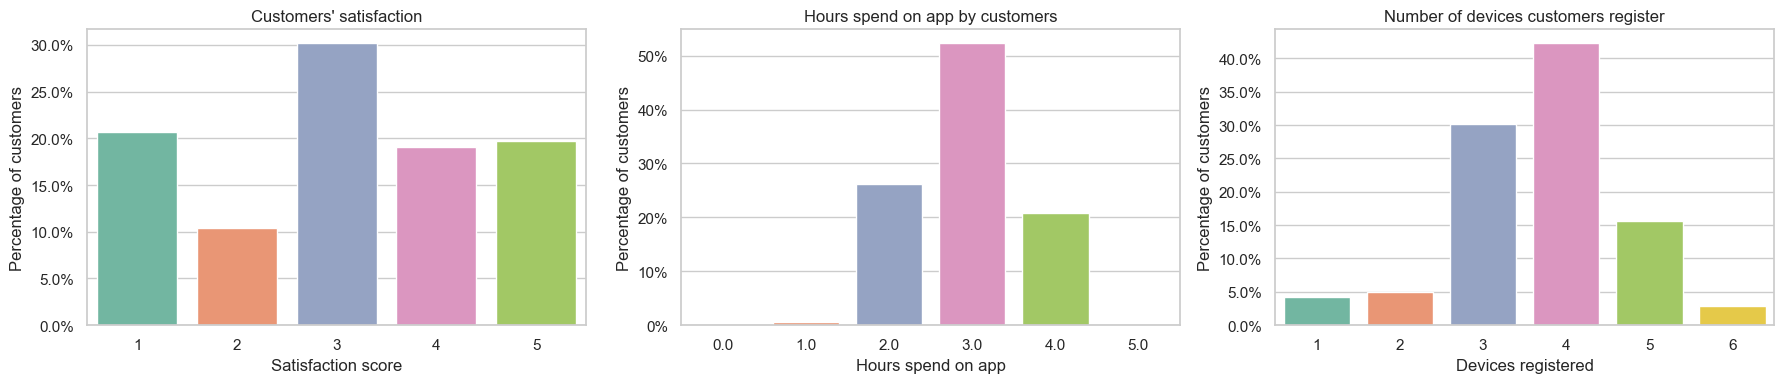

In [56]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

sns.barplot(data=satisfaction_score_percent,x='SatisfactionScore',y='percent',ax=ax[0])
ax[0].set_ylabel('Percentage of customers')
ax[0].set_xlabel('Satisfaction score')
ax[0].set_title("Customers' satisfaction")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=hours_spend_percent,x='HourSpendOnApp',y='percent',ax=ax[1])
ax[1].set_ylabel('Percentage of customers')
ax[1].set_xlabel('Hours spend on app')
ax[1].set_title('Hours spend on app by customers')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=devices_registered_percent,x='NumberOfDeviceRegistered',y='percent',ax=ax[2])
ax[2].set_ylabel('Percentage of customers')
ax[2].set_xlabel('Devices registered')
ax[2].set_title('Number of devices customers register') #this one is not as interesting as the others
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

* Under the assumption that a satifaction score of 1 is very unsatisfied and 5 is very satisfied, most of customers are neutral in satisfaction. 20% are very unsatisfied and 20% are very satistied.
* The majority of customers spend around 2-4 hours on app.
* Around 70% of customers have 3 or 4 devices registered.

In [17]:
# Fixing outliers
churn_df['Tenure'] = np.where(churn_df['Tenure']>np.quantile(churn_df['Tenure'], 0.99),churn_df['Tenure'].median(),churn_df['Tenure'])
churn_df['WarehouseToHome'] = np.where(churn_df['WarehouseToHome']>np.quantile(churn_df['WarehouseToHome'], 0.99),churn_df['WarehouseToHome'].median(),churn_df['WarehouseToHome'])


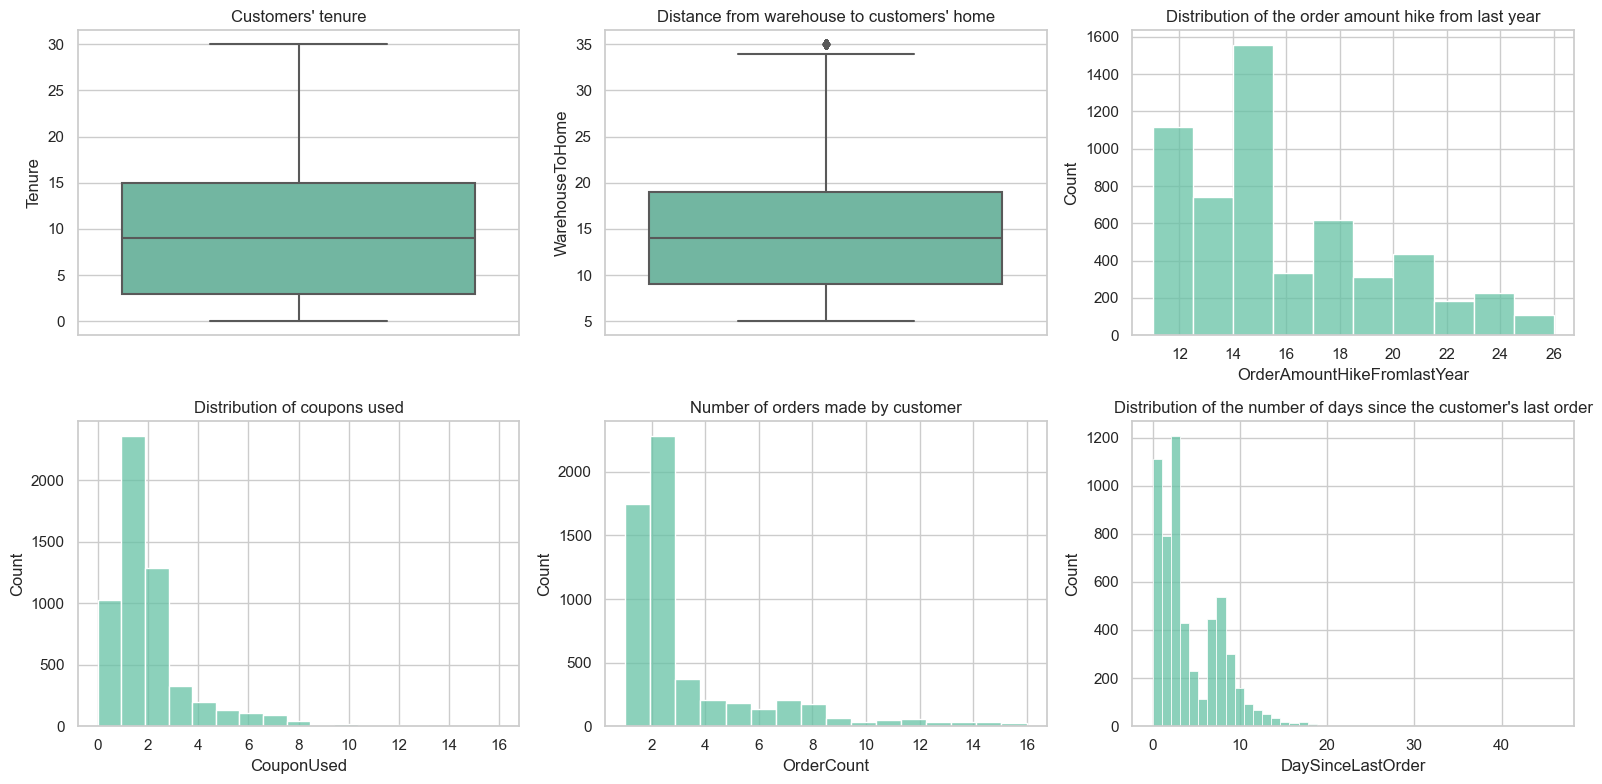

In [18]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.rcParams["figure.autolayout"] = True

sns.boxplot(data=churn_df, y='Tenure', ax= ax[0,0])
ax[0,0].set_title("Customers' tenure")

sns.boxplot(data=churn_df, y='WarehouseToHome', ax=ax[0,1])
ax[0,1].set_title("Distance from warehouse to customers' home")

sns.histplot(data=churn_df, x='OrderAmountHikeFromlastYear', ax=ax[0,2],bins=10)
ax[0,2].set_title("Distribution of the order amount hike from last year")

sns.histplot(data=churn_df, x='CouponUsed',ax=ax[1,0], bins=17)
ax[1,0].set_title("Distribution of coupons used")

sns.histplot(data=churn_df, x='OrderCount',ax=ax[1,1],bins=16)
ax[1,1].set_title("Number of orders made by customer")

sns.histplot(data=churn_df, x='DaySinceLastOrder',ax=ax[1,2],bins=44)
ax[1,2].set_title("Distribution of the number of days since the customer's last order")

plt.show()

According to the charts above:
* The median tenure of the clients is around 9 years and most of them have purchased with the company from more than 4 years and less than 15 years. Which means that there are several loyal customers.
* 75% of the clients live in less than 19km away from the warehouse.
* Most customers have an order amount hike of 15 purchases.
* Most customers have only used one or two counpons, or not even used them.
* Most customers have only made 2 or 3 orders, this might reflect the behavior of new customers.
* Most customers have bought recently, since their last order was made in the last 3 days. So we can say we have a lot of new customers at the moment, becuase most of them have only made 2 or 3 purchases.

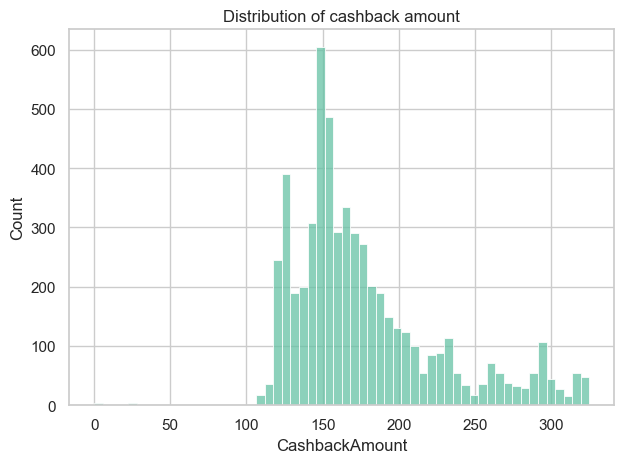

In [19]:
ax= sns.histplot(data=churn_df, x='CashbackAmount')
ax.set_title('Distribution of cashback amount');

* On average, customers have a cashback amount of 177, and there are a couple of them who reach the 300 or more.
* There are only a few customers who dont have cashback, which means that the ecommerce store has good rewards for customers.

## Finding patterns

Which features might be good indicators of churn?
* Tenure (Do we have loyal customers?)
* CashbackAmount (Is the cashback retaining customers?)
* OrderCount (Do they churn after a couple of months or they just purchase once and churn?)
* Complain (Is complaining a sign of churn?)
* DaySinceLastOrder (Do customers churn just a couple of days after their last order or does it take more time?)
* PreferedOrderCategory (Are the products from a specific category making the customers churn?)
* PreferedPaymentMode (Are there signs of a problem with the payment mode that is making customers churn?)

We are going to explore the performance of these features and its relation with Churn, nevertheless, for the model creation, all features will be analyzed to find their importance value.

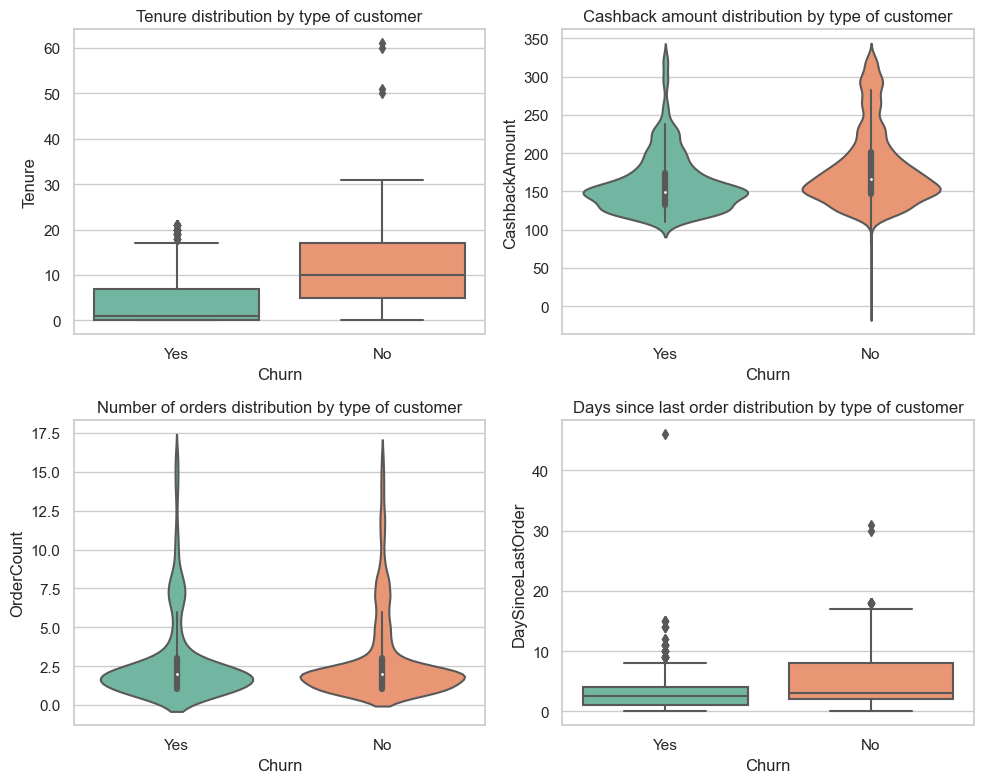

In [62]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
plt.rcParams["figure.autolayout"] = True

sns.boxplot(data=churn_df, y='Tenure', ax= ax[0,0],x='churn_flag')
ax[0,0].set_title('Tenure distribution by type of customer')
ax[0,0].set_xlabel('Churn')

sns.violinplot(data=churn_df, y='CashbackAmount',ax=ax[0,1],x='churn_flag')
ax[0,1].set_title('Cashback amount distribution by type of customer')
ax[0,1].set_xlabel('Churn')

sns.violinplot(data=churn_df, y='OrderCount',ax=ax[1,0],x='churn_flag')
ax[1,0].set_title('Number of orders distribution by type of customer')
ax[1,0].set_xlabel('Churn')

sns.boxplot(data=churn_df, y='DaySinceLastOrder', ax= ax[1,1],x='churn_flag')
ax[1,1].set_title('Days since last order distribution by type of customer')
ax[1,1].set_xlabel('Churn')

plt.show()

In [63]:
complain_churn = churn_df.groupby(['complain_flag','churn_flag'],as_index=False)['CustomerID'].count().merge(churn_df.groupby('complain_flag')['CustomerID'].count(), on='complain_flag')
complain_churn['percent'] = 100*complain_churn['CustomerID_x'] / complain_churn['CustomerID_y']

cat_churn = churn_df.groupby(['PreferedOrderCat','churn_flag'],as_index=False)['CustomerID'].count().merge(churn_df.groupby('PreferedOrderCat')['CustomerID'].count(), on='PreferedOrderCat')
cat_churn['percent'] = 100*cat_churn['CustomerID_x'] / cat_churn['CustomerID_y']

payment_churn = churn_df.groupby(['PreferredPaymentMode','churn_flag'],as_index=False)['CustomerID'].count().merge(churn_df.groupby('PreferredPaymentMode')['CustomerID'].count(), on='PreferredPaymentMode')
payment_churn['percent'] = 100*payment_churn['CustomerID_x'] / payment_churn['CustomerID_y']

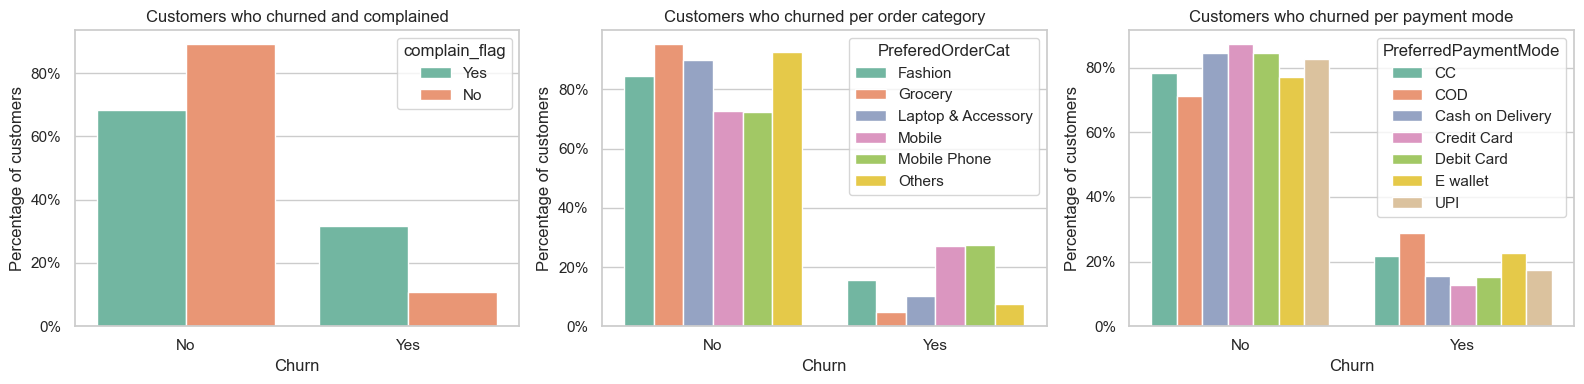

In [64]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
plt.rcParams["figure.autolayout"] = True

sns.barplot(data=complain_churn, hue='complain_flag',ax=ax[0],x='churn_flag',y='percent',hue_order=['Yes','No'])
ax[0].set_title('Customers who churned and complained')

sns.barplot(data=cat_churn, x='churn_flag',ax=ax[1],hue='PreferedOrderCat',y='percent')
ax[1].set_title('Customers who churned per order category')

sns.barplot(data=payment_churn, hue='PreferredPaymentMode', ax= ax[2],y='percent', x='churn_flag')
ax[2].set_title('Customers who churned per payment mode')

for i in range(3):
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Percentage of customers')
    ax[i].set_xlabel('Churn')

plt.show()

What can we say so far?
* It seems like new customers are more probable to churn. 
* The cashback amount is not a motivation for customers to stay, either the orders that they have made.
* It seems like people who have recently bought products have mostly churned, so this might be a recent problem.
* There is a 30% probability that customers will churn if they have complained and a 10% probability that they will churn too even if they haven't complain. So, there is 20% more probability of churn once a customer has complain.
* It is more likely that customers will churn if they buy mobiles or mobile phones, than any other product.
* Customers who pay with COD, CC or eWallet are more likely to churn (+20%), than if they choose any other payment method.

## Classification model to predict churn

Change categorical features into dummy features

In [65]:
churn_df['CityTier'] = churn_df['CityTier'].astype('category')

In [66]:
churn_dummies = pd.get_dummies(churn_df.drop(['CustomerID','churn_flag','complain_flag'],axis=1))

The following models will be fitted:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes
* Neural Networks

Because only 20% of the customers have churned, there is more information for the models to predict customers who haven't churned, therefore is will be more difficult for the model to find the pattern to predict those cases. That being said, we are going resample the training set in order to have a balanced data for the model to be trained.

In [67]:
# splitting data into train and test sets
X = churn_dummies.drop(['Churn'],axis=1)
y = churn_dummies['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [68]:
# Oversampling the training set to have a balanced dataset to fit the models
# This will increase the accuracy of the results

ros = RandomOverSampler(random_state=50)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [69]:
# These models are fitted first, the rest are fitted with more arguments specified
models = {'DecisionTree':DecisionTreeClassifier(),'RandomForest':RandomForestClassifier(),'NaiveBayes':GaussianNB()}

for model in models:
    initialize = models[model]
    fitted_model = initialize.fit(X_res, y_res)
    prediction = fitted_model.predict(X_test)
    print(model)
    print(classification_report(y_test, prediction,zero_division=1))
    print(confusion_matrix(y_test,prediction))

DecisionTree
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1402
           1       0.86      0.87      0.86       287

    accuracy                           0.95      1689
   macro avg       0.92      0.92      0.92      1689
weighted avg       0.95      0.95      0.95      1689

[[1361   41]
 [  38  249]]
RandomForest
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1402
           1       0.91      0.85      0.88       287

    accuracy                           0.96      1689
   macro avg       0.94      0.92      0.93      1689
weighted avg       0.96      0.96      0.96      1689

[[1379   23]
 [  42  245]]
NaiveBayes
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1402
           1       0.30      0.78      0.44       287

    accuracy                           0.66      1689
   macro avg       0.62      0.71    

In [70]:
# Multilayer neural network
mnn = MLPClassifier(solver='adam', alpha=0.00005,
                     hidden_layer_sizes=(5, 4),
                     activation='logistic', max_iter=1000)
mnn.fit(X_res, y_res)
prediction = mnn.predict(X_test)
print('Multilayer perceptron classifier')
print(classification_report(y_test, prediction,zero_division=0))
print(confusion_matrix(y_test,prediction))

Multilayer perceptron classifier
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1402
           1       0.57      0.83      0.68       287

    accuracy                           0.86      1689
   macro avg       0.77      0.85      0.79      1689
weighted avg       0.89      0.86      0.87      1689

[[1222  180]
 [  49  238]]


In [71]:
logistic = LogisticRegression(max_iter=1000, solver='liblinear')
model = logistic.fit(X_res,y_res)
prediction = model.predict(X_test)
print(classification_report(y_test,prediction))
print(confusion_matrix(y_test, prediction))


              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1402
           1       0.47      0.80      0.59       287

    accuracy                           0.81      1689
   macro avg       0.71      0.81      0.74      1689
weighted avg       0.87      0.81      0.83      1689

[[1143  259]
 [  57  230]]


Since the purpose of the model is to predict *Churn*, then it is important to have high Accuracy and high Recall values, and the Random Forest model satisfies better this requirements. We can see than its accuracy is 98%, and the model has predicted 245 customers who churned while the total amount was 287, 85% of the customers were well classified for the class of interest.

# Conclussions
* The Ecommerce platform seems to have a small but growing problem of churn, since the most common churns have been with customers with less tenure.
* Mobile and Mobile phones categories are the categories with more churned customers.
* The COD payment method might be causing problems to customers since it has more churn customers.
* If a customer has complained, there is 20% more probability that the customer will churn.
* Satisfaction metrics must be improved.